In [1]:
import collections
import inspect
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

import litholog
from litholog.defaults import gs2litho
from litholog.utils import string2array_pandas

In [2]:
litholog.__file__, dir(litholog)

('/opt/anaconda3/lib/python3.8/site-packages/litholog/__init__.py',
 ['Bed',
  'BedSequence',
  '__builtins__',
  '__cached__',
  '__doc__',
  '__file__',
  '__loader__',
  '__name__',
  '__package__',
  '__path__',
  '__spec__',
  'bed',
  'defaults',
  'sequence',
  'utils',
  'wentworth'])

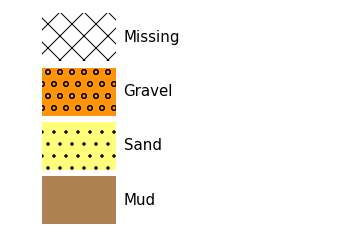

In [3]:
litholog.defaults.litholegend.plot()

# Load All Sequences

Here's a function (modified from `depstrat.data`) to load all the sequences as `BedSequence`s: 

In [9]:
# Set up some default args:

FPATH = '../data/working2.csv'

# Columns to convert from strings to arrays
transforms = {c : string2array_pandas for c in ['depth_m', 'grain_size_mm', 'grain_size_psi']}


# binary indicators
BINARY_FEATURES = ['snd_shl']


# bed data columns
FLOAT_FEATURES = [
    'th',
    'gs_tops_mm',
    'mean_gs_mm',
    'max_gs_mm',
    'grain_size_mm',
    'depth_m'
]

FEATURES = BINARY_FEATURES + FLOAT_FEATURES


# Sequence-level metadata
METACOLS = ['name', 'collection', 'ng', 'ar']


# Lithology component map
COMPONENT_MAP = ('max_gs_mm', lambda gs: gs2litho(gs, units='mm'))

In [10]:
def load_sequences(
    fpath=FPATH,
    resample=None,
    depth_col='depth_m',
    features=FEATURES,
    metacols=METACOLS,
    min_length=3
):
    """
    Load the dataset from saved csv. Return list of BedSequences.
    """
    df = pd.read_csv(fpath, converters=transforms)

    bed_seqs = []
    for name, grp in df.groupby('name'):
        seq = litholog.BedSequence.from_dataframe(
                grp,
                topcol='tops',
                thickcol='th', #basecol='bases',
                component_map=COMPONENT_MAP,
                datacols=features,
                metacols=metacols
        )
        if len(seq) >= min_length:
            bed_seqs.append(seq)
        
        # For quick checks
        #if len(bed_seqs) > 10:
        #    break

    # resample arrays if you want
    for seq in bed_seqs:
        if resample is not None:
            seq.resample_data(depth_col, resample)

    return bed_seqs

In [11]:
sequences = load_sequences()

# Hurst Values

In [13]:
# Just ones longer than 20 sand beds
seqs = list(filter(lambda s: len(s.get_field('th', 'sand')) >= 20, sequences))
len(seqs)

9

In [14]:
seqs[0][0].primary.lithology

'sand'

In [16]:
data = []

for s in seqs:
    sdata = {}
    for feature, take_log in zip(['th', 'mean_gs_mm'], [True, False]):
        D, p, K = s.hurst_D(feature, 'sand', take_log=take_log, nsamples=5000, return_K=True)
        sdata.update({f'D_{feature}': D, f'p_{feature}': p, f'K_{feature}': K})
    data.append({**sdata, **s.metadata, 'len': len(s)})
            
def get_array(data, field):
    return np.array([d[field] for d in data])

In [17]:
data[0]

{'D_th': 2.873644536973763,
 'p_th': 0.0002,
 'K_th': 0.822415107209811,
 'D_mean_gs_mm': 3.1524250585431126,
 'p_mean_gs_mm': 0.0002,
 'K_mean_gs_mm': 0.8443108475942092,
 'name': 'Karoo krf1',
 'collection': 'Skoorsteenberg',
 'ng': 0.772614886,
 'ar': 0.104761905,
 'len': 105}

In [14]:
labels = get_array(data, 'eodnum')
class_names = ['basin_plain', 'fan', 'slopechannel', 'levee']

(array([ 17.,   0.,   0.,  98.,   0.,   0., 101.,   0.,   0.,  36.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

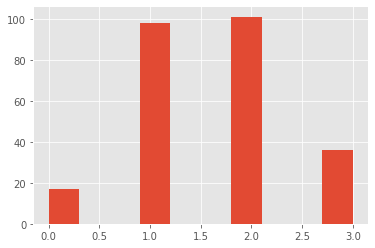

In [15]:
plt.hist(labels)

(array([149.,  20.,  13.,  17.,   8.,  11.,  11.,   7.,   9.,   7.]),
 array([0.    , 0.0985, 0.197 , 0.2955, 0.394 , 0.4925, 0.591 , 0.6895,
        0.788 , 0.8865, 0.985 ]),
 <a list of 10 Patch objects>)

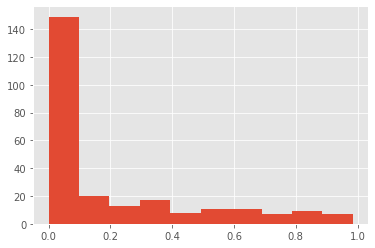

In [16]:
K_th = get_array(data, 'K_th')
D_th = get_array(data, 'D_th')
pvals = get_array(data, 'p_th')

plt.hist(pvals)

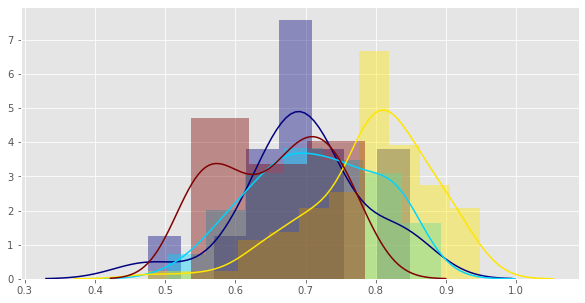

In [17]:
import seaborn as sns

cmap = plt.cm.get_cmap('jet', 4)

fig, ax = plt.subplots(figsize=(10, 5))

for i in range(4):
    K = K_th[np.where(labels==i)]
    ax = sns.distplot(K, color=cmap(i))

[Text(1, 0, 'basin plain'),
 Text(1, 0, 'fan'),
 Text(1, 0, 'slopechannel'),
 Text(1, 0, 'levee')]

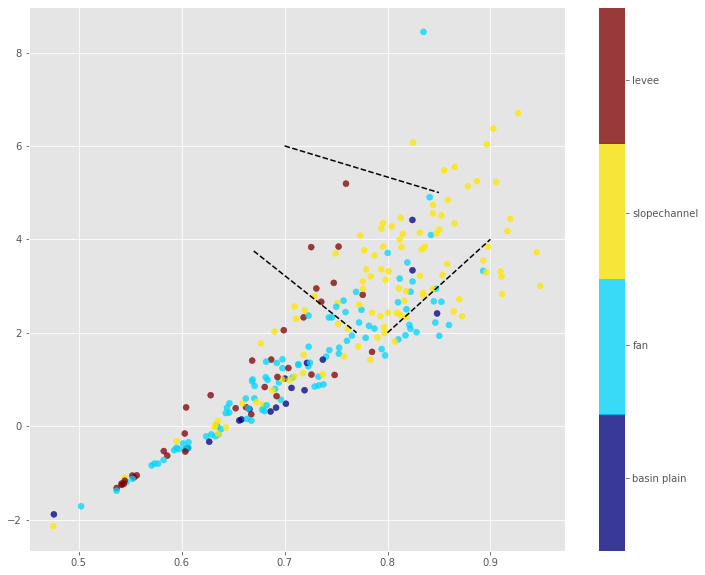

In [18]:
cmap = plt.cm.get_cmap('jet', 4)

fig, ax = plt.subplots(figsize=(12, 10))
#ax.set_aspect('equal')

ax.plot([0.67, 0.77], [3.75, 2.0], 'k--')
ax.plot([0.8, 0.9], [2, 4], 'k--')
ax.plot([0.7, 0.85], [6, 5], 'k--')

sc = plt.scatter(K_th, D_th, c=labels, cmap=cmap, alpha=0.75)

cbar = plt.colorbar(sc, ticks=np.linspace(0.4, 2.6, num=4))
cbar.ax.set_yticklabels(['basin plain', 'fan', 'slopechannel', 'levee'])

[Text(1, 0, 'basin plain'),
 Text(1, 0, 'fan'),
 Text(1, 0, 'slopechannel'),
 Text(1, 0, 'levee')]

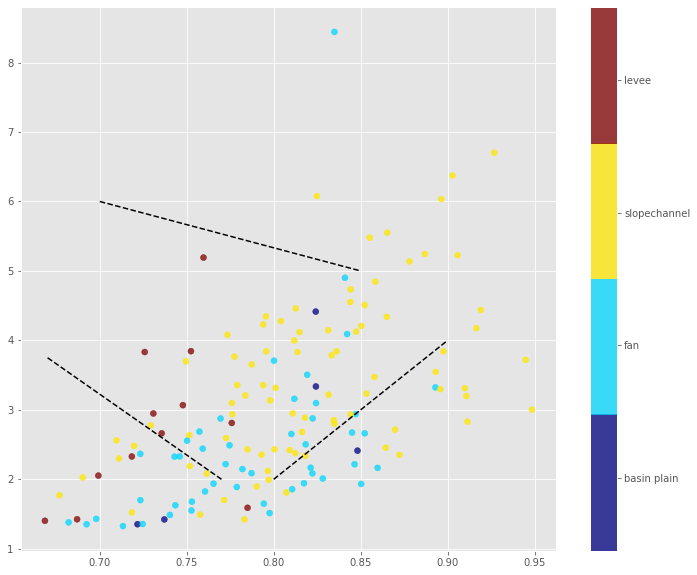

In [19]:
max_p = 0.1

_K_th = K_th[np.where(pvals < max_p)]
_D_th = D_th[np.where(pvals < max_p)]
_labels = labels[np.where(pvals < max_p)]

fig, ax = plt.subplots(figsize=(12, 10))
#ax.set_aspect('equal')

ax.plot([0.67, 0.77], [3.75, 2.0], 'k--')
ax.plot([0.8, 0.9], [2, 4], 'k--')
ax.plot([0.7, 0.85], [6, 5], 'k--')

sc = plt.scatter(_K_th, _D_th, c=_labels, cmap=cmap, alpha=0.75)

cbar = plt.colorbar(sc, ticks=np.linspace(0.4, 2.6, num=4))
cbar.ax.set_yticklabels(['basin plain', 'fan', 'slopechannel', 'levee'])

(array([161.,  19.,  11.,   9.,   7.,  14.,   6.,   9.,   6.,  10.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

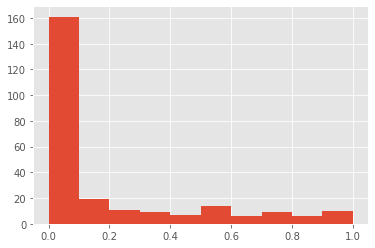

In [20]:
K_gs = get_array(data, 'K_mean_gs_psi')
D_gs = get_array(data, 'D_mean_gs_psi')
pvals = get_array(data, 'p_mean_gs_psi')

plt.hist(pvals)

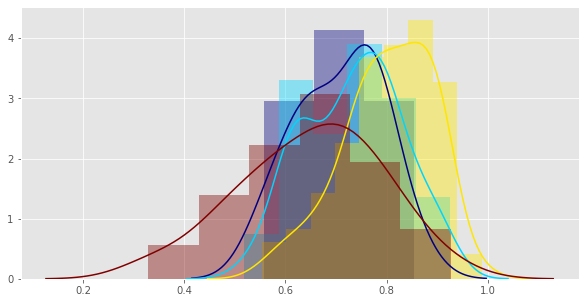

In [21]:
cmap = plt.cm.get_cmap('jet', 4)

fig, ax = plt.subplots(figsize=(10, 5))

for i in range(4):
    K = K_gs[np.where(labels==i)]
    ax = sns.distplot(K, color=cmap(i))

[Text(1, 0, 'basin plain'),
 Text(1, 0, 'fan'),
 Text(1, 0, 'slopechannel'),
 Text(1, 0, 'levee')]

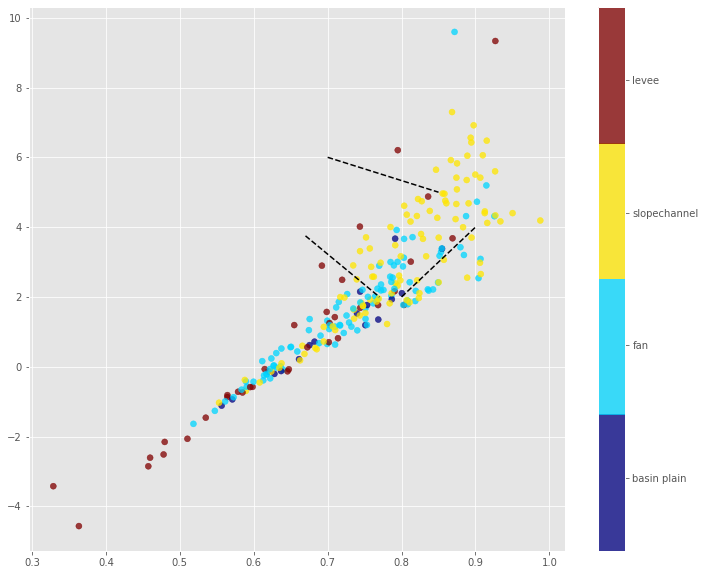

In [22]:
cmap = plt.cm.get_cmap('jet', 4)

fig, ax = plt.subplots(figsize=(12, 10))
#ax.set_aspect('equal')

ax.plot([0.67, 0.77], [3.75, 2.0], 'k--')
ax.plot([0.8, 0.9], [2, 4], 'k--')
ax.plot([0.7, 0.85], [6, 5], 'k--')

sc = plt.scatter(K_gs, D_gs, c=labels, cmap=cmap, alpha=0.75)

cbar = plt.colorbar(sc, ticks=np.linspace(0.4, 2.6, num=4))
cbar.ax.set_yticklabels(['basin plain', 'fan', 'slopechannel', 'levee'])

[Text(1, 0, 'basin plain'),
 Text(1, 0, 'fan'),
 Text(1, 0, 'slopechannel'),
 Text(1, 0, 'levee')]

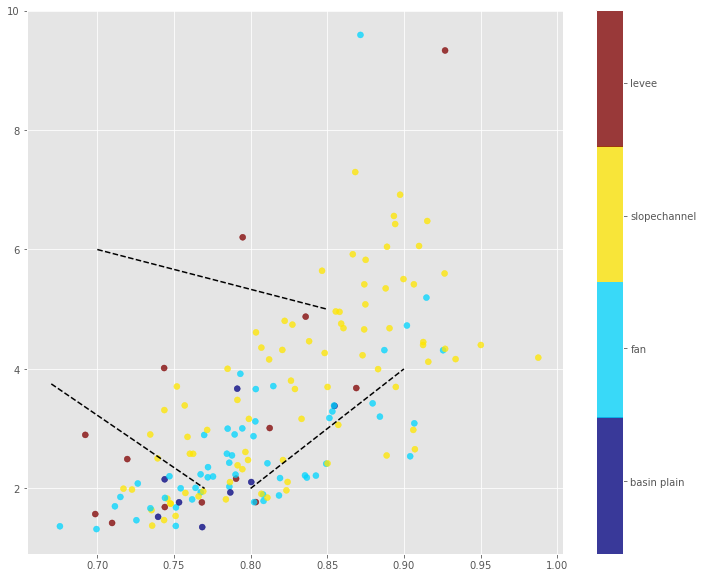

In [23]:
max_p = 0.1

_K_gs = K_gs[np.where(pvals < max_p)]
_D_gs = D_gs[np.where(pvals < max_p)]
_labels = labels[np.where(pvals < max_p)]

fig, ax = plt.subplots(figsize=(12, 10))
#ax.set_aspect('equal')

ax.plot([0.67, 0.77], [3.75, 2.0], 'k--')
ax.plot([0.8, 0.9], [2, 4], 'k--')
ax.plot([0.7, 0.85], [6, 5], 'k--')

sc = plt.scatter(_K_gs, _D_gs, c=_labels, cmap=cmap, alpha=0.75)

cbar = plt.colorbar(sc, ticks=np.linspace(0.4, 2.6, num=4))
cbar.ax.set_yticklabels(['basin plain', 'fan', 'slopechannel', 'levee'])

In [ ]:
vals = np.random.randint(0, 10, 10)
vals

In [ ]:
np.random.choice(vals, size=vals.size, replace=True)

In [ ]:
for s in seqs:
    print(s.hurst_D('mean_gs_psi'), len(s))

In [ ]:
for s in seqs:
    print(s.hurst_D('mean_gs_psi', nsamples=5000), len(s))

In [ ]:
d = {'a' : 1, 'b' : 2}
d2 = {'c' : 4, 'd': 5}

In [ ]:
d.update(d2)

In [ ]:
d

In [ ]:
seqs[0][0]

In [ ]:
def hurst_K(x, take_log=True, safe=True):
    """
    Comutes Hurst K ``log(R(n)/S(n)) / log(x.size / 2)`` for 1D array ``x``
    """
    x = np.array(x).squeeze()
    assert x.ndim == 1, 'Can only compute _rescaled_range on 1D series `x`'
    if safe and x.size < 20:
        raise UserWarning(f'Cannot use field of size {x.size} with ``safe=True``')

    if take_log:
        x = np.log10(x)

    y = x - x.mean()
    z = np.cumsum(y)
    
    Rn = z.max() - z.min()
    Sn = np.std(y)
    
    return np.log10(Rn / Sn) / np.log10(x.size / 2.)

def hurst_D(x, take_log=True, safe=True, nsamples=1000, return_K=True):
    """
    Returns (D, p, K) if ``return_K``, else (D, p)
    where:
        D : Bootstrapped Hurst value from ``nsamples`` resamples
        p : p-value of ``D``
        K : Hurst K value with original values
    """
    K = hurst_K(x, take_log=take_log, safe=safe)

    ks = np.zeros(nsamples)
    for i in range(nsamples):
        _sample = np.random.choice(x, size=x.size, replace=True)
        ks[i] = hurst_K(_sample, take_log=take_log, safe=safe)

    D = (K - ks.mean()) / ks.std()
    p = np.sum(ks >= K) / nsamples

    return (D, p, K) if return_K else (D, p)


x = np.random.randn(100) + 100
hurst_D(x)

In [ ]:
ks, ds, ps = [], [], []

for i in range(1000):
    x = np.random.randn(1000) + 100
    D, p, K = hurst_D(x)
    ks.append(K), ds.append(D), ps.append(p)

plt.hist(np.array(ks))

In [ ]:
plt.hist(np.array(ds))

In [ ]:
plt.hist(np.array(ps))

In [ ]:
np.mean(ds), np.std(ds)

In [ ]:
np.mean(ps), np.std(ps)

In [ ]:
np.mean(ks), np.std(ks)